In [1]:
%load_ext watermark


In [2]:
from IPython.display import display
import pandas as pd
import polars as pl
import seaborn as sns
from teeplot import teeplot as tp


In [3]:
%watermark -diwmuv -iv


Last updated: 2025-03-31T18:17:30.335001+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.8.0-1021-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

pandas : 2.2.3
seaborn: 0.13.2
teeplot: 1.2.0
polars : 1.9.0

Watermark: 2.4.3



In [4]:
teeplot_subdir = "wse-denovo-spatial2d-poisson-genomes"
teeplot_subdir


'wse-denovo-spatial2d-poisson-genomes'

## Prep Data


In [5]:
dfxs = pl.from_pandas(
    pd.read_parquet("https://osf.io/rpbwg/download"),
)
display(dfxs.describe()), display(dfxs.head()), display(dfxs.tail());


statistic,data_hex,is_extant,fitness,tile,row,col,genomeFlavor,globalSeed,nCol,nRow,nWav,nTrait,nCycle,nColSubgrid,nRowSubgrid,nonBlock,tilePopSize,tournSize,msec,tsc,replicate,netbencount_hexoffset,netbencount_hexwidth,mutator_hexoffset,mutator_hexwidth,delcount_hexoffset,delcount_hexwidth,counter_hexoffset,counter_hexwidth,snapshot_netbencount_hexoffset,snapshot_netbencount_hexwidth,snapshot_counter_hexoffset,snapshot_counter_hexwidth,snapshot_counter_dilation,_compconf_dummy,CEREBRASLIB_HYPERMUT_NUM_AVAIL_BEN_MUTS,CEREBRASLIB_TRAITLOGGER_NUM_BITS,CEREBRASLIB_TRAITLOGGER_DSTREAM_ALGO_NAME,CEREBRASLIB_TRAITLOGGER_DILATION,ASYNC_GA_GENOME_FLAVOR
str,str,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,str
"""count""","""22365000""",2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,"""22365000""",2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,"""22365000""",2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,"""22365000""",2.2365e7,"""22365000"""
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""",0.0,"""0"""
"""mean""",null,1.0,17.917253,372749.5,496.5,374.5,null,15.5,750.0,994.0,3.0,2.0,300000.0,0.0,0.0,0.0,256.0,1.1,0.0,0.0,null,0.0,4.0,4.0,2.0,6.0,2.0,8.0,8.0,16.0,4.0,20.0,4.0,8.0,42.0,18.0,256.0,null,8.0,null
"""std""",null,null,4.224545,215207.317651,286.942945,216.506163,null,8.655442,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.242641,0.0,null,0.0,null
"""min""","""0001000c0004702ebeef0ace""",1.0,9.0,0.0,0.0,0.0,null,1.0,750.0,994.0,3.0,2.0,300000.0,0.0,0.0,0.0,256.0,1.1,0.0,0.0,null,0.0,4.0,4.0,2.0,6.0,2.0,8.0,8.0,16.0,4.0,20.0,4.0,8.0,42.0,12.0,256.0,null,8.0,null
"""25%""",null,null,15.0,186375.0,248.0,187.0,null,8.0,750.0,994.0,3.0,2.0,300000.0,0.0,0.0,null,256.0,1.1,0.0,0.0,null,0.0,4.0,4.0,2.0,6.0,2.0,8.0,8.0,16.0,4.0,20.0,4.0,8.0,42.0,15.0,256.0,null,8.0,null
"""50%""",null,null,18.0,372750.0,497.0,375.0,null,16.0,750.0,994.0,3.0,2.0,300000.0,0.0,0.0,null,256.0,1.1,0.0,0.0,null,0.0,4.0,4.0,2.0,6.0,2.0,8.0,8.0,16.0,4.0,20.0,4.0,8.0,42.0,18.0,256.0,null,8.0,null
"""75%""",null,null,21.0,559124.0,745.0,562.0,null,23.0,750.0,994.0,3.0,2.0,300000.0,0.0,0.0,null,256.0,1.1,0.0,0.0,null,0.0,4.0,4.0,2.0,6.0,2.0,8.0,8.0,16.0,4.0,20.0,4.0,8.0,42.0,21.0,256.0,null,8.0,null
"""max""","""0664000f00048003002e0001""",1.0,24.0,745499.0,993.0,749.0,null,30.0,750.0,994.0,3.0,2.0,300000.0,0.0,0.0,0.0,256.0,1.1,0.0,0.0,null,0.0,4.0,4.0,2.0,6.0,2.0,8.0,8.0,16.0,4.0,20.0,4.0,8.0,42.0,24.0,256.0,null,8.0,null


data_hex,is_extant,fitness,tile,row,col,genomeFlavor,globalSeed,nCol,nRow,nWav,nTrait,nCycle,nColSubgrid,nRowSubgrid,nonBlock,tilePopSize,tournSize,msec,tsc,replicate,netbencount_hexoffset,netbencount_hexwidth,mutator_hexoffset,mutator_hexwidth,delcount_hexoffset,delcount_hexwidth,counter_hexoffset,counter_hexwidth,snapshot_netbencount_hexoffset,snapshot_netbencount_hexwidth,snapshot_counter_hexoffset,snapshot_counter_hexwidth,snapshot_counter_dilation,_compconf_dummy,CEREBRASLIB_HYPERMUT_NUM_AVAIL_BEN_MUTS,CEREBRASLIB_TRAITLOGGER_NUM_BITS,CEREBRASLIB_TRAITLOGGER_DSTREAM_ALGO_NAME,CEREBRASLIB_TRAITLOGGER_DILATION,ASYNC_GA_GENOME_FLAVOR
str,bool,f32,u32,u16,u16,cat,u32,u16,u16,u8,u8,u32,u16,u16,bool,u16,f32,f32,u64,cat,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u32,i16,u32,cat,u32,cat
"""0001000c000473cabeef0ace""",true,12.0,0,0,0,"""genome_hypermutator_cappedxl_d…",1,750,994,3,2,300000,0,0,false,256,1.1,0.0,0,"""93a0f38e-bfd5-4257-bade-2a1aab…",0,4,4,2,6,2,8,8,16,4,20,4,8,42,12,256,"""hybrid_0_steady_1_stretched_2_…",8,"""genome_hypermutator_cappedxl_d…"
"""0001000c000478f2beef0ace""",true,12.0,1,0,1,"""genome_hypermutator_cappedxl_d…",1,750,994,3,2,300000,0,0,false,256,1.1,0.0,0,"""93a0f38e-bfd5-4257-bade-2a1aab…",0,4,4,2,6,2,8,8,16,4,20,4,8,42,12,256,"""hybrid_0_steady_1_stretched_2_…",8,"""genome_hypermutator_cappedxl_d…"
"""0001000c000478f8beef0ace""",true,12.0,2,0,2,"""genome_hypermutator_cappedxl_d…",1,750,994,3,2,300000,0,0,false,256,1.1,0.0,0,"""93a0f38e-bfd5-4257-bade-2a1aab…",0,4,4,2,6,2,8,8,16,4,20,4,8,42,12,256,"""hybrid_0_steady_1_stretched_2_…",8,"""genome_hypermutator_cappedxl_d…"
"""0001000c000478febeef0ace""",true,12.0,3,0,3,"""genome_hypermutator_cappedxl_d…",1,750,994,3,2,300000,0,0,false,256,1.1,0.0,0,"""93a0f38e-bfd5-4257-bade-2a1aab…",0,4,4,2,6,2,8,8,16,4,20,4,8,42,12,256,"""hybrid_0_steady_1_stretched_2_…",8,"""genome_hypermutator_cappedxl_d…"
"""0001000c000478f7beef0ace""",true,12.0,4,0,4,"""genome_hypermutator_cappedxl_d…",1,750,994,3,2,300000,0,0,false,256,1.1,0.0,0,"""93a0f38e-bfd5-4257-bade-2a1aab…",0,4,4,2,6,2,8,8,16,4,20,4,8,42,12,256,"""hybrid_0_steady_1_stretched_2_…",8,"""genome_hypermutator_cappedxl_d…"


data_hex,is_extant,fitness,tile,row,col,genomeFlavor,globalSeed,nCol,nRow,nWav,nTrait,nCycle,nColSubgrid,nRowSubgrid,nonBlock,tilePopSize,tournSize,msec,tsc,replicate,netbencount_hexoffset,netbencount_hexwidth,mutator_hexoffset,mutator_hexwidth,delcount_hexoffset,delcount_hexwidth,counter_hexoffset,counter_hexwidth,snapshot_netbencount_hexoffset,snapshot_netbencount_hexwidth,snapshot_counter_hexoffset,snapshot_counter_hexwidth,snapshot_counter_dilation,_compconf_dummy,CEREBRASLIB_HYPERMUT_NUM_AVAIL_BEN_MUTS,CEREBRASLIB_TRAITLOGGER_NUM_BITS,CEREBRASLIB_TRAITLOGGER_DSTREAM_ALGO_NAME,CEREBRASLIB_TRAITLOGGER_DILATION,ASYNC_GA_GENOME_FLAVOR
str,bool,f32,u32,u16,u16,cat,u32,u16,u16,u8,u8,u32,u16,u16,bool,u16,f32,f32,u64,cat,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u32,i16,u32,cat,u32,cat
"""0064001800047a8000300001""",true,24.0,745495,993,745,"""genome_hypermutator_cappedxl_d…",30,750,994,3,2,300000,0,0,false,256,1.1,0.0,0,"""1c63611f-1aec-4e9a-afd4-67a2a5…",0,4,4,2,6,2,8,8,16,4,20,4,8,42,24,256,"""hybrid_0_steady_1_stretched_2_…",8,"""genome_hypermutator_cappedxl_d…"
"""0064001800047a5b00300001""",true,24.0,745496,993,746,"""genome_hypermutator_cappedxl_d…",30,750,994,3,2,300000,0,0,false,256,1.1,0.0,0,"""1c63611f-1aec-4e9a-afd4-67a2a5…",0,4,4,2,6,2,8,8,16,4,20,4,8,42,24,256,"""hybrid_0_steady_1_stretched_2_…",8,"""genome_hypermutator_cappedxl_d…"
"""0064001800047b3a00310001""",true,24.0,745497,993,747,"""genome_hypermutator_cappedxl_d…",30,750,994,3,2,300000,0,0,false,256,1.1,0.0,0,"""1c63611f-1aec-4e9a-afd4-67a2a5…",0,4,4,2,6,2,8,8,16,4,20,4,8,42,24,256,"""hybrid_0_steady_1_stretched_2_…",8,"""genome_hypermutator_cappedxl_d…"
"""0064001800047a9200300001""",true,24.0,745498,993,748,"""genome_hypermutator_cappedxl_d…",30,750,994,3,2,300000,0,0,false,256,1.1,0.0,0,"""1c63611f-1aec-4e9a-afd4-67a2a5…",0,4,4,2,6,2,8,8,16,4,20,4,8,42,24,256,"""hybrid_0_steady_1_stretched_2_…",8,"""genome_hypermutator_cappedxl_d…"
"""006400180004761100310001""",true,24.0,745499,993,749,"""genome_hypermutator_cappedxl_d…",30,750,994,3,2,300000,0,0,false,256,1.1,0.0,0,"""1c63611f-1aec-4e9a-afd4-67a2a5…",0,4,4,2,6,2,8,8,16,4,20,4,8,42,24,256,"""hybrid_0_steady_1_stretched_2_…",8,"""genome_hypermutator_cappedxl_d…"


In [6]:
def correct_endianness(name: str) -> pl.Expr:
    offset = name + "_hexoffset"
    width = name + "_hexwidth"
    return (
        pl.col(offset)
        - pl.col(offset).mod(8)
        + pl.col(offset).mod(8).xor(7)
        - (pl.col(width) - 1)
    )


In [7]:
dfys = dfxs.with_columns(
    netbencount_hexoffset=pl.lit(0, dtype=pl.UInt8),
    netbencount_hexwidth=pl.lit(4, dtype=pl.UInt8),
    mutator_hexoffset=pl.lit(4, dtype=pl.UInt8),
    mutator_hexwidth=pl.lit(2, dtype=pl.UInt8),
    delcount_hexoffset=pl.lit(6, dtype=pl.UInt8),
    delcount_hexwidth=pl.lit(2, dtype=pl.UInt8),
    counter_hexoffset=pl.lit(8, dtype=pl.UInt8),
    counter_hexwidth=pl.lit(8, dtype=pl.UInt8),
    snapshot_netbencount_hexoffset=pl.lit(16, dtype=pl.UInt8),
    snapshot_netbencount_hexwidth=pl.lit(4, dtype=pl.UInt8),
    snapshot_counter_hexoffset=pl.lit(20, dtype=pl.UInt8),
    snapshot_counter_hexwidth=pl.lit(4, dtype=pl.UInt8),
    snapshot_counter_dilation=pl.lit(256, dtype=pl.UInt16),
).with_columns(
    netbencount_hexoffset=correct_endianness("netbencount"),
    mutator_hexoffset=correct_endianness("mutator"),
    delcount_hexoffset=correct_endianness("delcount"),
    counter_hexoffset=correct_endianness("counter"),
    snapshot_netbencount_hexoffset=correct_endianness("snapshot_netbencount"),
    snapshot_counter_hexoffset=correct_endianness("snapshot_counter"),
)

display(dfys.describe()), display(dfys.head()), display(dfys.tail());


statistic,data_hex,is_extant,fitness,tile,row,col,genomeFlavor,globalSeed,nCol,nRow,nWav,nTrait,nCycle,nColSubgrid,nRowSubgrid,nonBlock,tilePopSize,tournSize,msec,tsc,replicate,netbencount_hexoffset,netbencount_hexwidth,mutator_hexoffset,mutator_hexwidth,delcount_hexoffset,delcount_hexwidth,counter_hexoffset,counter_hexwidth,snapshot_netbencount_hexoffset,snapshot_netbencount_hexwidth,snapshot_counter_hexoffset,snapshot_counter_hexwidth,snapshot_counter_dilation,_compconf_dummy,CEREBRASLIB_HYPERMUT_NUM_AVAIL_BEN_MUTS,CEREBRASLIB_TRAITLOGGER_NUM_BITS,CEREBRASLIB_TRAITLOGGER_DSTREAM_ALGO_NAME,CEREBRASLIB_TRAITLOGGER_DILATION,ASYNC_GA_GENOME_FLAVOR
str,str,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,str
"""count""","""22365000""",2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,"""22365000""",2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,"""22365000""",2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,"""22365000""",2.2365e7,"""22365000"""
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""",0.0,"""0"""
"""mean""",null,1.0,17.917253,372749.5,496.5,374.5,null,15.5,750.0,994.0,3.0,2.0,300000.0,0.0,0.0,0.0,256.0,1.1,0.0,0.0,null,4.0,4.0,2.0,2.0,0.0,2.0,8.0,8.0,20.0,4.0,16.0,4.0,256.0,42.0,18.0,256.0,null,8.0,null
"""std""",null,null,4.224545,215207.317651,286.942945,216.506163,null,8.655442,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.242641,0.0,null,0.0,null
"""min""","""0001000c0004702ebeef0ace""",1.0,9.0,0.0,0.0,0.0,null,1.0,750.0,994.0,3.0,2.0,300000.0,0.0,0.0,0.0,256.0,1.1,0.0,0.0,null,4.0,4.0,2.0,2.0,0.0,2.0,8.0,8.0,20.0,4.0,16.0,4.0,256.0,42.0,12.0,256.0,null,8.0,null
"""25%""",null,null,15.0,186375.0,248.0,187.0,null,8.0,750.0,994.0,3.0,2.0,300000.0,0.0,0.0,null,256.0,1.1,0.0,0.0,null,4.0,4.0,2.0,2.0,0.0,2.0,8.0,8.0,20.0,4.0,16.0,4.0,256.0,42.0,15.0,256.0,null,8.0,null
"""50%""",null,null,18.0,372750.0,497.0,375.0,null,16.0,750.0,994.0,3.0,2.0,300000.0,0.0,0.0,null,256.0,1.1,0.0,0.0,null,4.0,4.0,2.0,2.0,0.0,2.0,8.0,8.0,20.0,4.0,16.0,4.0,256.0,42.0,18.0,256.0,null,8.0,null
"""75%""",null,null,21.0,559124.0,745.0,562.0,null,23.0,750.0,994.0,3.0,2.0,300000.0,0.0,0.0,null,256.0,1.1,0.0,0.0,null,4.0,4.0,2.0,2.0,0.0,2.0,8.0,8.0,20.0,4.0,16.0,4.0,256.0,42.0,21.0,256.0,null,8.0,null
"""max""","""0664000f00048003002e0001""",1.0,24.0,745499.0,993.0,749.0,null,30.0,750.0,994.0,3.0,2.0,300000.0,0.0,0.0,0.0,256.0,1.1,0.0,0.0,null,4.0,4.0,2.0,2.0,0.0,2.0,8.0,8.0,20.0,4.0,16.0,4.0,256.0,42.0,24.0,256.0,null,8.0,null


data_hex,is_extant,fitness,tile,row,col,genomeFlavor,globalSeed,nCol,nRow,nWav,nTrait,nCycle,nColSubgrid,nRowSubgrid,nonBlock,tilePopSize,tournSize,msec,tsc,replicate,netbencount_hexoffset,netbencount_hexwidth,mutator_hexoffset,mutator_hexwidth,delcount_hexoffset,delcount_hexwidth,counter_hexoffset,counter_hexwidth,snapshot_netbencount_hexoffset,snapshot_netbencount_hexwidth,snapshot_counter_hexoffset,snapshot_counter_hexwidth,snapshot_counter_dilation,_compconf_dummy,CEREBRASLIB_HYPERMUT_NUM_AVAIL_BEN_MUTS,CEREBRASLIB_TRAITLOGGER_NUM_BITS,CEREBRASLIB_TRAITLOGGER_DSTREAM_ALGO_NAME,CEREBRASLIB_TRAITLOGGER_DILATION,ASYNC_GA_GENOME_FLAVOR
str,bool,f32,u32,u16,u16,cat,u32,u16,u16,u8,u8,u32,u16,u16,bool,u16,f32,f32,u64,cat,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u16,u32,i16,u32,cat,u32,cat
"""0001000c000473cabeef0ace""",true,12.0,0,0,0,"""genome_hypermutator_cappedxl_d…",1,750,994,3,2,300000,0,0,false,256,1.1,0.0,0,"""93a0f38e-bfd5-4257-bade-2a1aab…",4,4,2,2,0,2,8,8,20,4,16,4,256,42,12,256,"""hybrid_0_steady_1_stretched_2_…",8,"""genome_hypermutator_cappedxl_d…"
"""0001000c000478f2beef0ace""",true,12.0,1,0,1,"""genome_hypermutator_cappedxl_d…",1,750,994,3,2,300000,0,0,false,256,1.1,0.0,0,"""93a0f38e-bfd5-4257-bade-2a1aab…",4,4,2,2,0,2,8,8,20,4,16,4,256,42,12,256,"""hybrid_0_steady_1_stretched_2_…",8,"""genome_hypermutator_cappedxl_d…"
"""0001000c000478f8beef0ace""",true,12.0,2,0,2,"""genome_hypermutator_cappedxl_d…",1,750,994,3,2,300000,0,0,false,256,1.1,0.0,0,"""93a0f38e-bfd5-4257-bade-2a1aab…",4,4,2,2,0,2,8,8,20,4,16,4,256,42,12,256,"""hybrid_0_steady_1_stretched_2_…",8,"""genome_hypermutator_cappedxl_d…"
"""0001000c000478febeef0ace""",true,12.0,3,0,3,"""genome_hypermutator_cappedxl_d…",1,750,994,3,2,300000,0,0,false,256,1.1,0.0,0,"""93a0f38e-bfd5-4257-bade-2a1aab…",4,4,2,2,0,2,8,8,20,4,16,4,256,42,12,256,"""hybrid_0_steady_1_stretched_2_…",8,"""genome_hypermutator_cappedxl_d…"
"""0001000c000478f7beef0ace""",true,12.0,4,0,4,"""genome_hypermutator_cappedxl_d…",1,750,994,3,2,300000,0,0,false,256,1.1,0.0,0,"""93a0f38e-bfd5-4257-bade-2a1aab…",4,4,2,2,0,2,8,8,20,4,16,4,256,42,12,256,"""hybrid_0_steady_1_stretched_2_…",8,"""genome_hypermutator_cappedxl_d…"


data_hex,is_extant,fitness,tile,row,col,genomeFlavor,globalSeed,nCol,nRow,nWav,nTrait,nCycle,nColSubgrid,nRowSubgrid,nonBlock,tilePopSize,tournSize,msec,tsc,replicate,netbencount_hexoffset,netbencount_hexwidth,mutator_hexoffset,mutator_hexwidth,delcount_hexoffset,delcount_hexwidth,counter_hexoffset,counter_hexwidth,snapshot_netbencount_hexoffset,snapshot_netbencount_hexwidth,snapshot_counter_hexoffset,snapshot_counter_hexwidth,snapshot_counter_dilation,_compconf_dummy,CEREBRASLIB_HYPERMUT_NUM_AVAIL_BEN_MUTS,CEREBRASLIB_TRAITLOGGER_NUM_BITS,CEREBRASLIB_TRAITLOGGER_DSTREAM_ALGO_NAME,CEREBRASLIB_TRAITLOGGER_DILATION,ASYNC_GA_GENOME_FLAVOR
str,bool,f32,u32,u16,u16,cat,u32,u16,u16,u8,u8,u32,u16,u16,bool,u16,f32,f32,u64,cat,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u16,u32,i16,u32,cat,u32,cat
"""0064001800047a8000300001""",true,24.0,745495,993,745,"""genome_hypermutator_cappedxl_d…",30,750,994,3,2,300000,0,0,false,256,1.1,0.0,0,"""1c63611f-1aec-4e9a-afd4-67a2a5…",4,4,2,2,0,2,8,8,20,4,16,4,256,42,24,256,"""hybrid_0_steady_1_stretched_2_…",8,"""genome_hypermutator_cappedxl_d…"
"""0064001800047a5b00300001""",true,24.0,745496,993,746,"""genome_hypermutator_cappedxl_d…",30,750,994,3,2,300000,0,0,false,256,1.1,0.0,0,"""1c63611f-1aec-4e9a-afd4-67a2a5…",4,4,2,2,0,2,8,8,20,4,16,4,256,42,24,256,"""hybrid_0_steady_1_stretched_2_…",8,"""genome_hypermutator_cappedxl_d…"
"""0064001800047b3a00310001""",true,24.0,745497,993,747,"""genome_hypermutator_cappedxl_d…",30,750,994,3,2,300000,0,0,false,256,1.1,0.0,0,"""1c63611f-1aec-4e9a-afd4-67a2a5…",4,4,2,2,0,2,8,8,20,4,16,4,256,42,24,256,"""hybrid_0_steady_1_stretched_2_…",8,"""genome_hypermutator_cappedxl_d…"
"""0064001800047a9200300001""",true,24.0,745498,993,748,"""genome_hypermutator_cappedxl_d…",30,750,994,3,2,300000,0,0,false,256,1.1,0.0,0,"""1c63611f-1aec-4e9a-afd4-67a2a5…",4,4,2,2,0,2,8,8,20,4,16,4,256,42,24,256,"""hybrid_0_steady_1_stretched_2_…",8,"""genome_hypermutator_cappedxl_d…"
"""006400180004761100310001""",true,24.0,745499,993,749,"""genome_hypermutator_cappedxl_d…",30,750,994,3,2,300000,0,0,false,256,1.1,0.0,0,"""1c63611f-1aec-4e9a-afd4-67a2a5…",4,4,2,2,0,2,8,8,20,4,16,4,256,42,24,256,"""hybrid_0_steady_1_stretched_2_…",8,"""genome_hypermutator_cappedxl_d…"


In [8]:
print(
    f'{dfys["data_hex"].str.len_bytes().unique().item()=}',
    f'{dfys["delcount_hexoffset"].unique().item()=}',
    f'{dfys["mutator_hexoffset"].unique().item()=}',
    f'{dfys["snapshot_netbencount_hexoffset"].unique().item()=}',
    f'{dfys["snapshot_counter_hexoffset"].unique().item()=}',
    sep="\n",
)


dfys["data_hex"].str.len_bytes().unique().item()=24
dfys["delcount_hexoffset"].unique().item()=0
dfys["mutator_hexoffset"].unique().item()=2
dfys["snapshot_netbencount_hexoffset"].unique().item()=20
dfys["snapshot_counter_hexoffset"].unique().item()=16


In [9]:
dfzs = dfys.with_columns(
    mutator=pl.col("data_hex")
    .str.slice(
        int(dfys["mutator_hexoffset"].unique().item()),
        int(dfys["mutator_hexwidth"].unique().item()),
    )
    .str.to_integer(base=16),
    snapshot_netbencount=pl.col("data_hex")
    .str.slice(
        int(dfys["snapshot_netbencount_hexoffset"].unique().item()),
        int(dfys["snapshot_netbencount_hexwidth"].unique().item()),
    )
    .str.to_integer(base=16),
    snapshot_counter=pl.col("data_hex")
    .str.slice(
        int(dfys["snapshot_counter_hexoffset"].unique().item()),
        int(dfys["snapshot_counter_hexwidth"].unique().item()),
    )
    .str.to_integer(base=16),
).with_columns(
    snapshot_counter=pl.col("snapshot_counter")
    * pl.col("snapshot_counter_dilation"),
)
dfzs


data_hex,is_extant,fitness,tile,row,col,genomeFlavor,globalSeed,nCol,nRow,nWav,nTrait,nCycle,nColSubgrid,nRowSubgrid,nonBlock,tilePopSize,tournSize,msec,tsc,replicate,netbencount_hexoffset,netbencount_hexwidth,mutator_hexoffset,mutator_hexwidth,delcount_hexoffset,delcount_hexwidth,counter_hexoffset,counter_hexwidth,snapshot_netbencount_hexoffset,snapshot_netbencount_hexwidth,snapshot_counter_hexoffset,snapshot_counter_hexwidth,snapshot_counter_dilation,_compconf_dummy,CEREBRASLIB_HYPERMUT_NUM_AVAIL_BEN_MUTS,CEREBRASLIB_TRAITLOGGER_NUM_BITS,CEREBRASLIB_TRAITLOGGER_DSTREAM_ALGO_NAME,CEREBRASLIB_TRAITLOGGER_DILATION,ASYNC_GA_GENOME_FLAVOR,mutator,snapshot_netbencount,snapshot_counter
str,bool,f32,u32,u16,u16,cat,u32,u16,u16,u8,u8,u32,u16,u16,bool,u16,f32,f32,u64,cat,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u16,u32,i16,u32,cat,u32,cat,i64,i64,i64
"""0001000c000473cabeef0ace""",true,12.0,0,0,0,"""genome_hypermutator_cappedxl_d…",1,750,994,3,2,300000,0,0,false,256,1.1,0.0,0,"""93a0f38e-bfd5-4257-bade-2a1aab…",4,4,2,2,0,2,8,8,20,4,16,4,256,42,12,256,"""hybrid_0_steady_1_stretched_2_…",8,"""genome_hypermutator_cappedxl_d…",1,2766,12513024
"""0001000c000478f2beef0ace""",true,12.0,1,0,1,"""genome_hypermutator_cappedxl_d…",1,750,994,3,2,300000,0,0,false,256,1.1,0.0,0,"""93a0f38e-bfd5-4257-bade-2a1aab…",4,4,2,2,0,2,8,8,20,4,16,4,256,42,12,256,"""hybrid_0_steady_1_stretched_2_…",8,"""genome_hypermutator_cappedxl_d…",1,2766,12513024
"""0001000c000478f8beef0ace""",true,12.0,2,0,2,"""genome_hypermutator_cappedxl_d…",1,750,994,3,2,300000,0,0,false,256,1.1,0.0,0,"""93a0f38e-bfd5-4257-bade-2a1aab…",4,4,2,2,0,2,8,8,20,4,16,4,256,42,12,256,"""hybrid_0_steady_1_stretched_2_…",8,"""genome_hypermutator_cappedxl_d…",1,2766,12513024
"""0001000c000478febeef0ace""",true,12.0,3,0,3,"""genome_hypermutator_cappedxl_d…",1,750,994,3,2,300000,0,0,false,256,1.1,0.0,0,"""93a0f38e-bfd5-4257-bade-2a1aab…",4,4,2,2,0,2,8,8,20,4,16,4,256,42,12,256,"""hybrid_0_steady_1_stretched_2_…",8,"""genome_hypermutator_cappedxl_d…",1,2766,12513024
"""0001000c000478f7beef0ace""",true,12.0,4,0,4,"""genome_hypermutator_cappedxl_d…",1,750,994,3,2,300000,0,0,false,256,1.1,0.0,0,"""93a0f38e-bfd5-4257-bade-2a1aab…",4,4,2,2,0,2,8,8,20,4,16,4,256,42,12,256,"""hybrid_0_steady_1_stretched_2_…",8,"""genome_hypermutator_cappedxl_d…",1,2766,12513024
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""0064001800047a8000300001""",true,24.0,745495,993,745,"""genome_hypermutator_cappedxl_d…",30,750,994,3,2,300000,0,0,false,256,1.1,0.0,0,"""1c63611f-1aec-4e9a-afd4-67a2a5…",4,4,2,2,0,2,8,8,20,4,16,4,256,42,24,256,"""hybrid_0_steady_1_stretched_2_…",8,"""genome_hypermutator_cappedxl_d…",100,1,12288
"""0064001800047a5b00300001""",true,24.0,745496,993,746,"""genome_hypermutator_cappedxl_d…",30,750,994,3,2,300000,0,0,false,256,1.1,0.0,0,"""1c63611f-1aec-4e9a-afd4-67a2a5…",4,4,2,2,0,2,8,8,20,4,16,4,256,42,24,256,"""hybrid_0_steady_1_stretched_2_…",8,"""genome_hypermutator_cappedxl_d…",100,1,12288
"""0064001800047b3a00310001""",true,24.0,745497,993,747,"""genome_hypermutator_cappedxl_d…",30,750,994,3,2,300000,0,0,false,256,1.1,0.0,0,"""1c63611f-1aec-4e9a-afd4-67a2a5…",4,4,2,2,0,2,8,8,20,4,16,4,256,42,24,256,"""hybrid_0_steady_1_stretched_2_…",8,"""genome_hypermutator_cappedxl_d…",100,1,12544


In [10]:
assert set(dfzs["mutator"].unique()) <= {1, 100}, dfzs["mutator"].unique()


In [11]:
df = dfzs.group_by("replicate").first()


## Plot Data


teeplots/wse-denovo-spatial2d-poisson-genomes/viz=catplot+x=cerebraslib-hypermut-num-avail-ben-muts+y=snapshot-netbencount+ext=.pdf
teeplots/wse-denovo-spatial2d-poisson-genomes/viz=catplot+x=cerebraslib-hypermut-num-avail-ben-muts+y=snapshot-netbencount+ext=.png


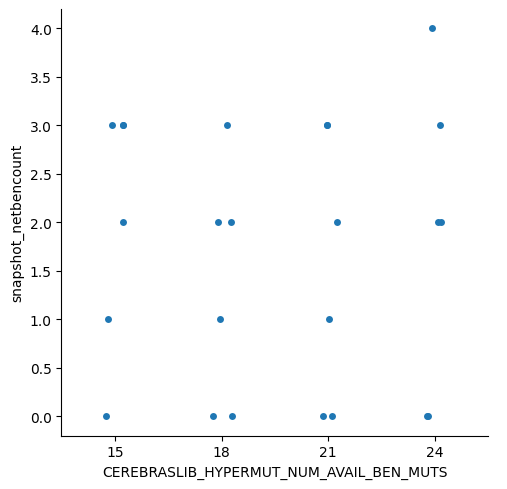

In [12]:
with tp.teed(
    sns.catplot,
    data=df.filter(
        pl.col("mutator") == 100,
    ),
    x="CEREBRASLIB_HYPERMUT_NUM_AVAIL_BEN_MUTS",
    y="snapshot_netbencount",
    teeplot_subdir=teeplot_subdir,
) as g:
    pass


teeplots/wse-denovo-spatial2d-poisson-genomes/col=cerebraslib-hypermut-num-avail-ben-muts+viz=catplot+y=snapshot-counter+ext=.pdf
teeplots/wse-denovo-spatial2d-poisson-genomes/col=cerebraslib-hypermut-num-avail-ben-muts+viz=catplot+y=snapshot-counter+ext=.png


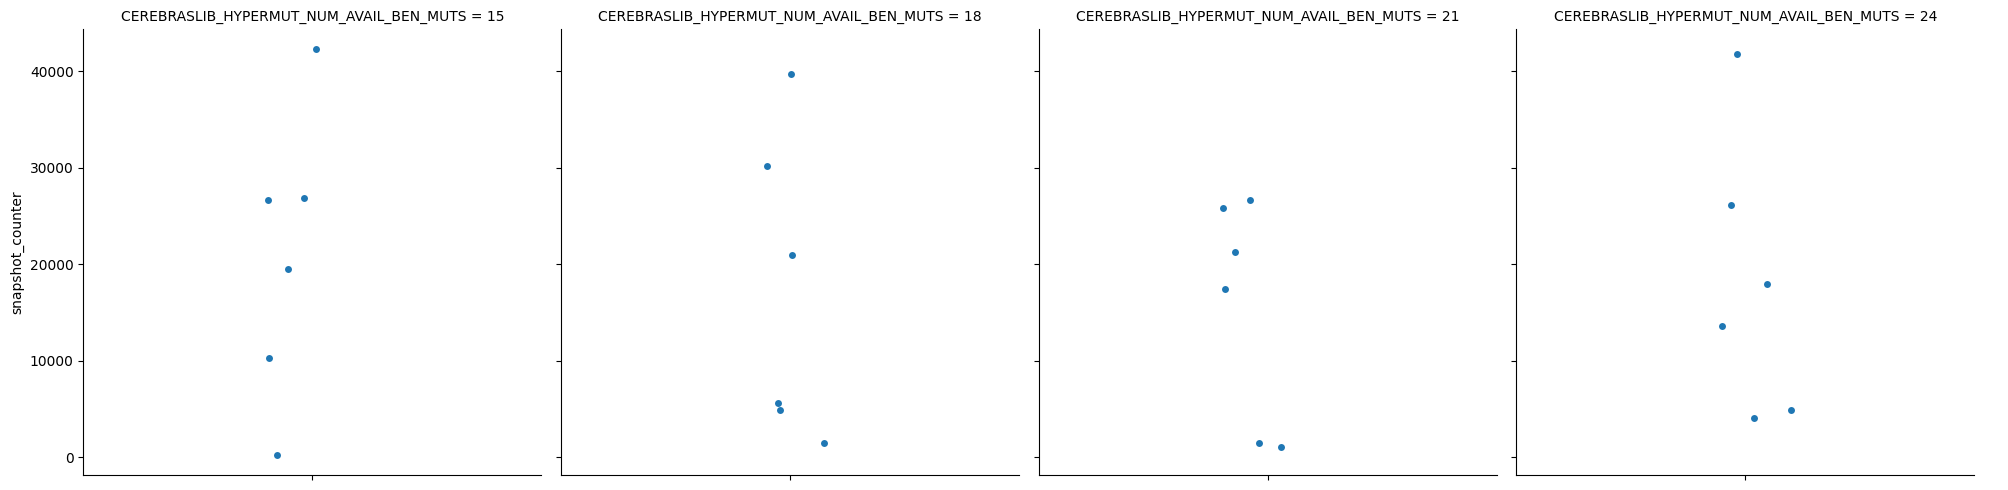

In [13]:
with tp.teed(
    sns.catplot,
    data=df.filter(
        pl.col("mutator") == 100,
    ),
    col="CEREBRASLIB_HYPERMUT_NUM_AVAIL_BEN_MUTS",
    y="snapshot_counter",
    teeplot_subdir=teeplot_subdir,
) as g:
    pass
